### 步骤1：数据预处理

In [1]:
#################步骤1：数据预处理#####################
import pandas as pd
import numpy as np

In [2]:
# 读取EMG数据（处理可能的异常值）
emg = pd.read_csv(
    'E:\\User_Stuff\\Documents\\Code_Typing\\Python_3.12_Code_Workspace\\SmallProject\\YOLO_handpose\\mediapipe\\跨模态动作识别项目开发\\emg_data_n250205.csv',
    header=0,          # 有标题行时需要设置header=0
    names=['time_ms', 'value'],
    converters={
        'time_ms': lambda x: float(x.strip() or 0),  # 处理空值
        'value': lambda x: float(x.strip() or 0)
    }
)

In [3]:
import pandas as pd

# 读取手部关键点数据（处理可能的无效坐标）
hands = pd.read_csv(
    'E:\\User_Stuff\\Documents\\Code_Typing\\Python_3.12_Code_Workspace\\SmallProject\\YOLO_handpose\\mediapipe\\跨模态动作识别项目开发\\hand_landmarks_n250205.csv',
    na_values=['-1', 'null', 'NaN']
)

# 定义 dtype
dtype = {col: float for col in hands.columns if col.startswith(('x_', 'y_'))}

# 应用 dtype 并丢弃无效行
hands = hands.astype(dtype).dropna()


In [4]:
import pandas as pd
# 读取手部关键点数据（处理可能的无效坐标）
hands = pd.read_csv(
    'E:\\User_Stuff\\Documents\\Code_Typing\\Python_3.12_Code_Workspace\\SmallProject\\YOLO_handpose\\mediapipe\\跨模态动作识别项目开发\\hand_landmarks_n250205.csv',
    dtype={col: float for col in hands.columns if col.startswith(('x_', 'y_'))},
    na_values=['-1', 'null', 'NaN']
).dropna()  # 丢弃无效行

In [5]:
# 转换时间单位
emg['time'] = emg['time_ms'] / 1000  # 转换为秒
hands['time'] = hands['frame_id'] / 30  # 假设视频30fps

In [6]:
# 验证数据格式
print("EMG数据样例:")
print(emg.head(3))
print("\n手部数据样例:")
print(hands.head(3))

EMG数据样例:
   time_ms  value  time
0      0.0  301.0  0.00
1     20.0  300.0  0.02
2     40.0  302.0  0.04

手部数据样例:
   frame_id    x_0    y_0    x_1    y_1   x_2    y_2   x_3    y_3   x_4  ...  \
0         0  176.0  101.0  116.0  142.0  78.0  201.0  60.0  254.0  38.0  ...   
1         1  173.0   98.0  114.0  139.0  77.0  199.0  61.0  256.0  40.0  ...   
2         2  173.0   97.0  115.0  138.0  77.0  199.0  61.0  255.0  39.0  ...   

    y_16   x_17   y_17   x_18   y_18   x_19   y_19   x_20   y_20      time  
0  402.0  264.0  234.0  294.0  277.0  312.0  306.0  326.0  333.0  0.000000  
1  403.0  264.0  233.0  296.0  278.0  313.0  307.0  325.0  335.0  0.033333  
2  401.0  265.0  233.0  296.0  278.0  313.0  308.0  325.0  335.0  0.066667  

[3 rows x 44 columns]


### 步骤2：自动检测同步事件

In [38]:
#############2.1 检测EMG中的突发动作################
from scipy.signal import find_peaks

# 带通滤波预处理
emg_raw = emg['value'].values
emg_filtered = emg_raw - np.convolve(emg_raw, np.ones(100)/100, mode='same')

# 寻找显著动作的起始点
emg_peaks, _ = find_peaks(emg_filtered,
                         height=np.percentile(emg_filtered, 10),
                         distance=100,  # 最小间隔1秒
                         prominence=20)  # 显著度要求

In [71]:
################2.2 检测视频中的手部运动################
# 计算手掌开合度变化率
hands['openness'] = np.sqrt(
    (hands['x_5'] - hands['x_0'])**2 +
    (hands['y_5'] - hands['y_0'])**2
)
hands['velocity'] = hands['openness'].diff().abs()

# 寻找手部动作起始帧
video_peaks, _ = find_peaks(hands['velocity'].fillna(0),
                           #height=np.percentile(hands['velocity'], 0.000001),
                           prominence=3.0)  # 最小间隔1秒 distance=30

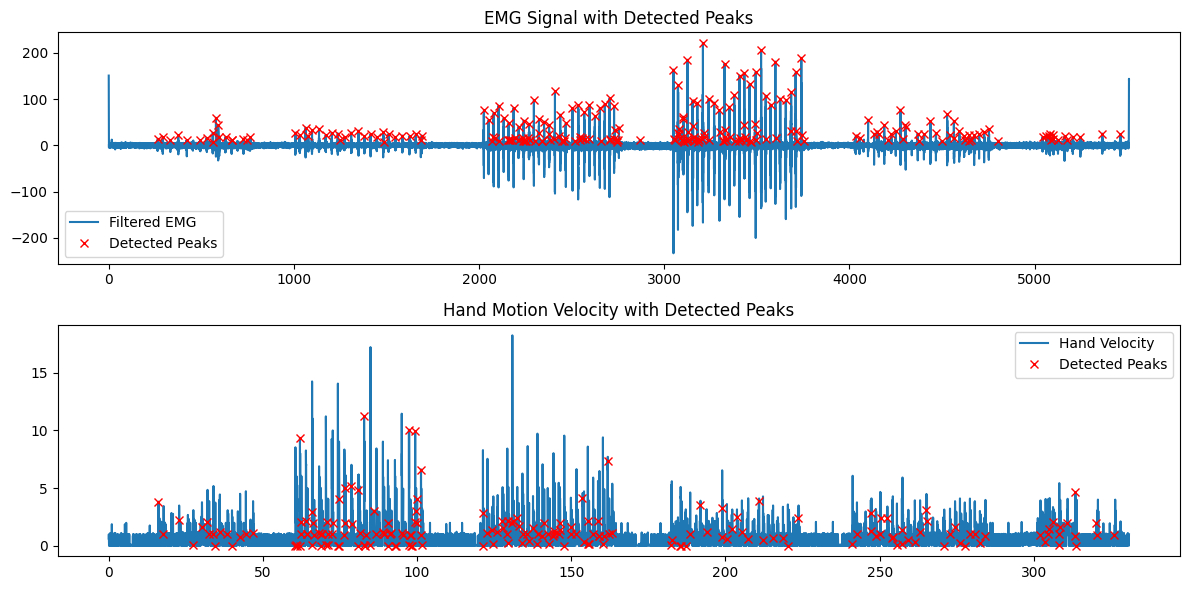

In [72]:
####################### 检查峰值检测结果 ########################

import matplotlib.pyplot as plt
# 可视化检测到的峰值
plt.figure(figsize=(12,6))

# EMG信号
plt.subplot(2,1,1)
plt.plot(emg['time'], emg_filtered, label='Filtered EMG')
plt.plot(emg['time'][emg_peaks], emg_filtered[emg_peaks], 'rx', label='Detected Peaks')
plt.title('EMG Signal with Detected Peaks')
plt.legend()

# 手部动作速度
plt.subplot(2,1,2)
plt.plot(hands['time'], hands['velocity'], label='Hand Velocity')
plt.plot(hands['time'][video_peaks], hands['velocity'][video_peaks], 'rx', label='Detected Peaks')
plt.title('Hand Motion Velocity with Detected Peaks')
plt.legend()

plt.tight_layout()
plt.show()

In [54]:
print(f"EMG peaks found: {len(emg_peaks)}")
print(f"Video peaks found: {len(video_peaks)}")

EMG peaks found: 238
Video peaks found: 160


### 步骤3：时间序列动态匹配
发现前六个数据点对应得非常好，决定根据前六个数据点进行时间序列动态匹配。

In [82]:
##########步骤1：提取前六个同步点##############

# 取前六个峰值
num_sync_points = 6
# emg_sync_times = emg['time'][emg_peaks[:num_sync_points]].values
# video_sync_times = hands['time'][video_peaks[:num_sync_points]].values


#########我受不了了，我手动取值！！！！！！！！！
emg_sync_times = [263.400,292.340,333.240,5366.400,5462.800]
video_sync_times = [16.33333333,18.00000000,20.50000000,320.66666667,326.50000000]

# 打印同步点时间
print("EMG Sync Times:", emg_sync_times)
print("Video Sync Times:", video_sync_times)

EMG Sync Times: [263.4, 292.34, 333.24, 5366.4, 5462.8]
Video Sync Times: [16.33333333, 18.0, 20.5, 320.66666667, 326.5]


In [89]:
#############步骤2：线性时间映射###############

# 计算时间偏移
from scipy.stats import linregress

slope, intercept, r_value, _, _ = linregress(video_sync_times, emg_sync_times)

print(f"Time Mapping: EMG_time = {slope:.4f} * Video_time + {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")

# 定义映射函数
def video_to_emg_time(video_time):
    video_time = np.array(video_time)
    return slope * video_time + intercept

Time Mapping: EMG_time = 16.7644 * Video_time + -10.0844
R-squared: 1.0000


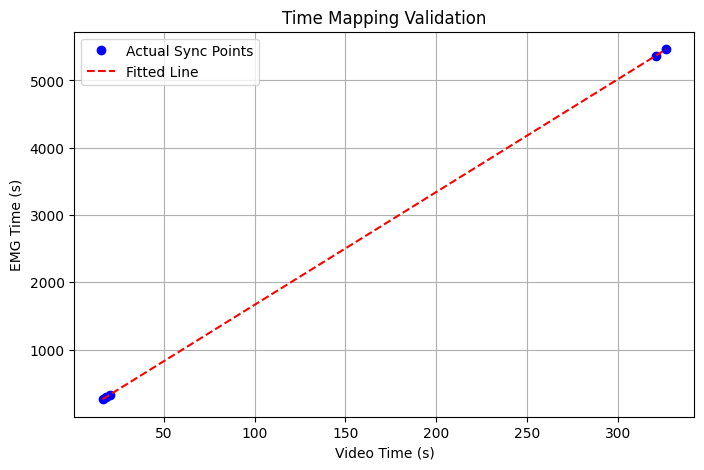

In [90]:
#############步骤3：验证映射效果###############

# 计算预测值
predicted_emg_times = video_to_emg_time(video_sync_times)

# 绘制拟合结果
plt.figure(figsize=(8,5))
plt.plot(video_sync_times, emg_sync_times, 'bo', label='Actual Sync Points')
plt.plot(video_sync_times, predicted_emg_times, 'r--', label='Fitted Line')
plt.xlabel('Video Time (s)')
plt.ylabel('EMG Time (s)')
plt.title('Time Mapping Validation')
plt.legend()
plt.grid(True)
plt.show()

In [87]:
#############步骤4：应用时间映射###############

# 为每个视频帧计算对应的EMG时间
hands['emg_time'] = hands['time'].apply(video_to_emg_time)

# 找到最近的EMG采样点
def find_nearest_emg_index(target_time):
    time_diff = np.abs(emg['time'] - target_time)
    return np.argmin(time_diff)

hands['emg_index'] = hands['emg_time'].apply(find_nearest_emg_index)

# 合并数据
merged_data = pd.merge_asof(
    hands.sort_values('emg_time'),
    emg.sort_values('time'),
    left_on='emg_time',
    right_on='time',
    direction='nearest'
)

# 保存结果
merged_data.to_csv('synced_data_6points_n250205.csv', index=False)

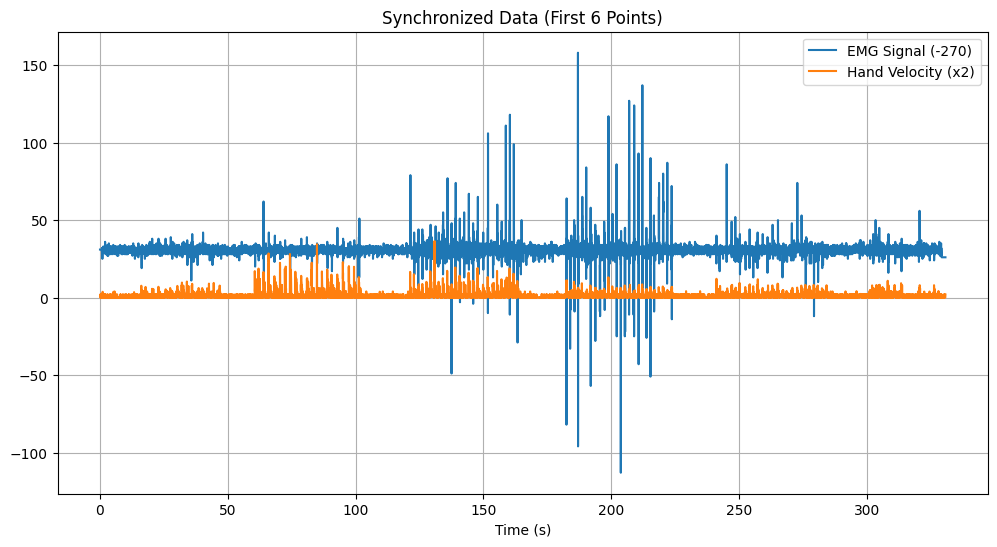

In [88]:
#################步骤5：结果验证###################

# 绘制同步后的数据
plt.figure(figsize=(12,6))
plt.plot(merged_data['time_x'], merged_data['value']-270, label='EMG Signal (-270)')
plt.plot(merged_data['time_x'], merged_data['velocity']*2, label='Hand Velocity (x2)')
plt.xlabel('Time (s)')
plt.title('Synchronized Data (First 6 Points)')
plt.legend()
plt.grid(True)
plt.show()

In [91]:
###################步骤6：残差分析验证模型效果###################

residuals = emg_sync_times - predicted_emg_times
print(f"Max Residual: {np.max(np.abs(residuals)):.3f}s")

Max Residual: 0.703s


# 之后的步骤即可舍弃了，因为我们已经找到了我认为的最佳的时间映射函数。

In [13]:
#############步骤3：时间序列动态匹配###############
from dtaidistance import dtw

# 生成候选匹配矩阵
emg_peak_times = emg['time'][emg_peaks].values
video_peak_times = hands['time'][video_peaks].values

# 动态时间规整对齐
distance_matrix = dtw.distance_matrix(emg_peak_times[:, None],
                                     video_peak_times[:, None])
path = dtw.warping_path(distance_matrix)

# 获取最优匹配对
matched_pairs = [(emg_peaks[i], video_peaks[j]) for i,j in path]

IndexError: index 0 is out of bounds for axis 0 with size 0

### 步骤4：构建全局时间映射函数

In [ ]:
##################步骤4：构建全局时间映射函数###################
from scipy.interpolate import interp1d

# 提取匹配点的时间对应关系
emg_match_times = emg['time'][[i for i,j in matched_pairs]].values
video_match_times = hands['time'][[j for i,j in matched_pairs]].values

# 创建三次样条插值函数
time_mapping = interp1d(video_match_times, emg_match_times,
                       kind='cubic', fill_value='extrapolate')

# 应用时间映射
hands['corrected_time'] = time_mapping(hands['time'])

### 步骤5：数据对齐验证

In [ ]:
#################步骤5：数据对齐验证#########################3
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(emg['time'], emg_filtered, label='EMG信号')
plt.plot(hands['corrected_time'], hands['velocity']*50, label='手部动作速度(x50)')
plt.xlabel('时间 (秒)')
plt.legend()
plt.title('同步验证图')
plt.show()

### 步骤6：生成最终对齐数据集

In [1]:
###################步骤6：生成最终对齐数据集###################
# 为每个视频帧找到最近的EMG数据索引
def find_nearest_emg(video_time):
    time_diff = np.abs(emg['time'] - video_time)
    return np.argmin(time_diff)

hands['emg_index'] = hands['corrected_time'].apply(find_nearest_emg)

# 合并数据集
merged_data = pd.merge_asof(
    hands.sort_values('corrected_time'),
    emg.sort_values('time'),
    left_on='corrected_time',
    right_on='time',
    direction='nearest'
)

# 保存结果
merged_data.to_csv('synced_dataset.csv', index=False)